In [1]:
import dask.dataframe as dd
from datetime import datetime
import intake
import numpy as np
import pandas as pd

In [2]:
from dask.diagnostics import ProgressBar
pbar = ProgressBar()
pbar.register()

In [3]:
import intake
from tqdm import tqdm

# cat = intake.Catalog('https://raw.githubusercontent.com/ContinuumIO/anaconda-package-data/master/catalog/anaconda_package_data.yaml')
# monthly = cat.anaconda_package_data_by_month(year=2019, month=12).to_dask()

In [4]:
datetime_count = {}

In [5]:
for year in [2017, 2018, 2019, 2020]:
    for month in tqdm(range(1, 13)):
        df = intake.cat.anaconda_package_data_by_month(year=year, month=month).to_dask()
        datetime_count[(year, month)] = df.loc[(df.data_source=='conda-forge')]['counts'].sum().compute()

  0%|          | 0/12 [00:00<?, ?it/s]

[########################################] | 100% Completed |  2.8s


  8%|▊         | 1/12 [00:12<02:12, 12.00s/it]

[########################################] | 100% Completed |  2.2s


 17%|█▋        | 2/12 [00:22<01:56, 11.64s/it]

[########################################] | 100% Completed |  2.9s


 25%|██▌       | 3/12 [00:36<01:49, 12.17s/it]

[########################################] | 100% Completed |  3.1s


 33%|███▎      | 4/12 [00:48<01:37, 12.21s/it]

[########################################] | 100% Completed |  3.0s


 42%|████▏     | 5/12 [01:00<01:25, 12.24s/it]

[########################################] | 100% Completed |  3.2s


 50%|█████     | 6/12 [01:13<01:14, 12.36s/it]

[########################################] | 100% Completed |  3.6s


 58%|█████▊    | 7/12 [01:25<01:01, 12.37s/it]

[########################################] | 100% Completed |  3.5s


 67%|██████▋   | 8/12 [01:38<00:49, 12.49s/it]

[########################################] | 100% Completed |  3.5s


 75%|███████▌  | 9/12 [01:50<00:37, 12.42s/it]

[########################################] | 100% Completed |  3.9s


 83%|████████▎ | 10/12 [02:04<00:25, 12.92s/it]

[########################################] | 100% Completed |  3.6s


 92%|█████████▏| 11/12 [02:17<00:12, 12.91s/it]

[########################################] | 100% Completed |  3.5s


  0%|          | 0/12 [00:00<?, ?it/s]

[########################################] | 100% Completed |  4.0s


  8%|▊         | 1/12 [00:13<02:29, 13.56s/it]

[########################################] | 100% Completed |  3.8s


 17%|█▋        | 2/12 [00:26<02:12, 13.24s/it]

[########################################] | 100% Completed |  4.7s


 25%|██▌       | 3/12 [00:40<02:02, 13.63s/it]

[########################################] | 100% Completed |  4.6s


 33%|███▎      | 4/12 [00:53<01:47, 13.46s/it]

[########################################] | 100% Completed |  4.8s


 42%|████▏     | 5/12 [01:07<01:35, 13.70s/it]

[########################################] | 100% Completed |  5.3s


 50%|█████     | 6/12 [01:22<01:24, 14.00s/it]

[########################################] | 100% Completed |  5.6s


 58%|█████▊    | 7/12 [01:37<01:11, 14.23s/it]

[########################################] | 100% Completed |  6.0s


 67%|██████▋   | 8/12 [01:53<00:59, 14.77s/it]

[########################################] | 100% Completed |  5.9s


 75%|███████▌  | 9/12 [02:08<00:44, 14.95s/it]

[########################################] | 100% Completed |  6.5s


 83%|████████▎ | 10/12 [02:25<00:31, 15.61s/it]

[########################################] | 100% Completed |  6.8s


 92%|█████████▏| 11/12 [02:42<00:15, 15.91s/it]

[########################################] | 100% Completed |  6.1s


  0%|          | 0/12 [00:00<?, ?it/s]

[########################################] | 100% Completed |  6.3s


  8%|▊         | 1/12 [00:16<02:58, 16.24s/it]

[########################################] | 100% Completed |  6.3s


 17%|█▋        | 2/12 [00:31<02:40, 16.08s/it]

[########################################] | 100% Completed |  7.2s


 25%|██▌       | 3/12 [00:48<02:26, 16.28s/it]

[########################################] | 100% Completed |  7.0s


 33%|███▎      | 4/12 [01:06<02:14, 16.78s/it]

[########################################] | 100% Completed |  7.3s


 42%|████▏     | 5/12 [01:23<01:58, 16.91s/it]

[########################################] | 100% Completed |  7.3s


 50%|█████     | 6/12 [01:41<01:43, 17.22s/it]

[########################################] | 100% Completed |  7.6s


 58%|█████▊    | 7/12 [02:00<01:27, 17.53s/it]

[########################################] | 100% Completed |  7.3s


 67%|██████▋   | 8/12 [02:17<01:09, 17.49s/it]

[########################################] | 100% Completed |  6.8s


 75%|███████▌  | 9/12 [02:35<00:53, 17.68s/it]

[########################################] | 100% Completed |  8.4s


 83%|████████▎ | 10/12 [02:54<00:36, 18.01s/it]

[########################################] | 100% Completed |  7.4s


 92%|█████████▏| 11/12 [03:13<00:18, 18.27s/it]

[########################################] | 100% Completed |  8.2s


  0%|          | 0/12 [00:00<?, ?it/s]

[########################################] | 100% Completed |  7.6s


  8%|▊         | 1/12 [00:18<03:24, 18.59s/it]

[########################################] | 100% Completed |  7.8s


 17%|█▋        | 2/12 [00:36<03:03, 18.34s/it]

[########################################] | 100% Completed |  8.7s


 25%|██▌       | 3/12 [00:55<02:48, 18.67s/it]

[########################################] | 100% Completed |  9.5s


 33%|███▎      | 4/12 [01:15<02:30, 18.82s/it]


IndexError: list index out of range

In [6]:
datetime_count

{(2017, 1): 0,
 (2017, 2): 0,
 (2017, 3): 701645,
 (2017, 4): 7375445,
 (2017, 5): 8261383,
 (2017, 6): 7535179,
 (2017, 7): 10039857,
 (2017, 8): 12408943,
 (2017, 9): 11690260,
 (2017, 10): 13837261,
 (2017, 11): 13064540,
 (2017, 12): 11730379,
 (2018, 1): 17343201,
 (2018, 2): 18564943,
 (2018, 3): 21064271,
 (2018, 4): 16748850,
 (2018, 5): 24040170,
 (2018, 6): 23831192,
 (2018, 7): 28815251,
 (2018, 8): 32511378,
 (2018, 9): 37050898,
 (2018, 10): 47325248,
 (2018, 11): 50874921,
 (2018, 12): 42107025,
 (2019, 1): 43062229,
 (2019, 2): 46763206,
 (2019, 3): 55879507,
 (2019, 4): 48684136,
 (2019, 5): 66728803,
 (2019, 6): 62462089,
 (2019, 7): 65210830,
 (2019, 8): 61969868,
 (2019, 9): 62608046,
 (2019, 10): 78757103,
 (2019, 11): 85271670,
 (2019, 12): 90225074,
 (2020, 1): 99275455,
 (2020, 2): 99000914,
 (2020, 3): 115990884,
 (2020, 4): 122603668}

In [30]:
datetime_count = {k: v for k, v in datetime_count.items() if v}

In [31]:
import pandas as pd

In [32]:
years = [k[0] for k in datetime_count]
months = [k[1] for k in datetime_count]
counts = [datetime_count[k] for k in zip(years, months)]

In [33]:
cdf = pd.DataFrame({'year': years, 'months': months, 'day': [1] * len(years)})

In [34]:
cdf['idx'] = pd.to_datetime(cdf)

In [35]:
cdf = cdf.set_index('idx')

In [36]:
cdf['counts'] = counts

In [37]:
import matplotlib.pyplot as plt

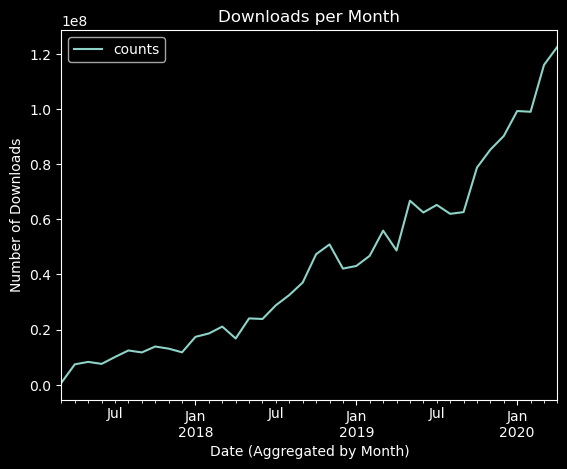

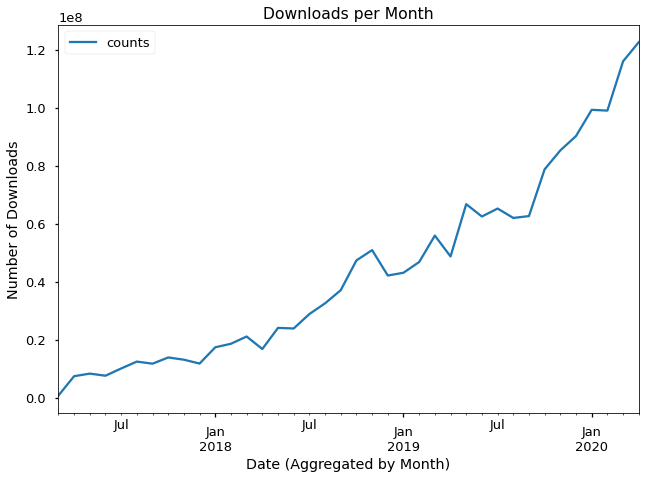

In [38]:
for context in [("dark_background", "seaborn-talk"), ("seaborn-talk", )]:
    with plt.style.context(*context):
        fig, ax = plt.subplots()
        cdf.plot(y='counts', ax=ax)
        ax.set_title(f"Downloads per Month")
        ax.set_xlabel("Date (Aggregated by Month)")
        ax.set_ylabel("Number of Downloads")
        fig.savefig(f"plots/downloads-{'_'.join(context)}.png", bbox_inches='tight', transparent=True)

In [39]:
cdf['counts'].sum()/1e9

1.661415722